# Steps

1. Bilddimension berechnen, nach Höhe, Einfangwinkel & Neigung
    * [M30T Fact sheet](https://enterprise.dji.com/matrice-30/specs): DFOV (Diagonal Field of View) 61deg 
3. Um den Yaw-Winkel drehen (alle Winkel müssen in rad angegeben werden und drehsinn gegen orientierungswinkel
4. Bild Verschieben um die Drohnenposi

# **Open**

- [x] ~Output: am besten ja direkt in ne posgres/gis datenbank~
    * ~dann kann ich das auch schon mal lernen und ist denke ich deutlich praktischer als shapefiles~
- [x] ~apply to all images in given folder~
- [x] ~eventually make it OOP~
- [ ] eventually add gimbal info and drone height for better filtering in qgis
  - zum beispiel gib mir alle bilder in diesem bereich, aus niedrieger höhe und vogelperspektieve oder schräg mit richtung xy
  - or is this possible to query without storing? from till meta files directly
- [ ] Beispiel Case bauen: nach object id oder grundstück
- [ ] **DOKUMENTATION NOTION**


# Geographische Operationen

* **Shapely** kann keine Koordinatensystem Transformationen.
  * alles ist einfach in Cartesischen Daten vorhanden und es muss sicher gestellt werden, dass die Punkte den gleichen Referenzpunkt haben
  * -> Da wir aber nur in SH unterwegs sind, sollte das aber kein Problem sein.
  * Note: Shapely benutzt die GEOS lib (genau wie PostGis) 
* **DJI** hat die Koordinaten in **LAT/LON Dezimalgrad**
* Da auch unsere QGIS Daten in **EPSG:25832** hinterlegt sind, werden die GPS Tags hierhin Transformiert
* [Example Transform | Docu](https://pyproj4.github.io/pyproj/stable/examples.html#step-2-create-transformer-to-convert-from-geodetic-crs-to-crs)

# Real Coordinates
1. put relative image_coordinates in a tuple for all corners of the image
2. apply rotation as given by drone data
3. move coordinates by drone position

$$tan(\alpha_{gimbal} + \beta) = \frac{y}{h} \ \rightarrow \beta : \text{camera opening in y-direction (from center)}$$
$$cos(\alpha_{gimbal} + \beta) = \frac{h}{s}$$
$$tan(\gamma) = \frac{x}{s} \ \rightarrow \gamma : \text{camera opening in x-direction (from center at the slope)}$$


In [1]:
import numpy as np
# import matplotlib.pyplot as plt
import exiftool
from PIL import Image

import shapely
from pyproj import Transformer, CRS

import psycopg

In [11]:
class M30TImage:

    # M30T specific
    # Must be adjusted if we use smaller drone from marc
    IMAGE_WIDTH = 640
    IMAGE_HEIGHT = 512
    DFOV: int = np.radians(61)
    IMAGE_RATIO : float = IMAGE_HEIGHT / IMAGE_WIDTH
    GROUND_DIAGONAL_ANLGE : float = np.arctan(IMAGE_RATIO)
    RELATIVE_HEIGHT = ((np.sqrt(IMAGE_HEIGHT**2 + IMAGE_WIDTH**2)) / 
                       (np.tan(DFOV / 2))
                      )
    Y_ANGLE = np.arctan(IMAGE_HEIGHT / RELATIVE_HEIGHT)
    SLOPE = IMAGE_HEIGHT / np.sin(Y_ANGLE) #length from camera to middle top end of Field of VIEW
    X_ANGLE = np.arctan(IMAGE_WIDTH / SLOPE) #Viewing angle at upper / lower sloping side to the middle to left / right 

    del GROUND_DIAGONAL_ANLGE, RELATIVE_HEIGHT, SLOPE
    
    def __init__(self, org_file_path):
        
        self.org_file_path = org_file_path
        
        with exiftool.ExifToolHelper() as et:
            self.meta_data = et.get_metadata(self.org_file_path)[0]
        
        # self.DRONE_HEIGHT = float(self.meta_data['XMP:RelativeAltitude'])
        self.DRONE_HEIGHT = 6.813
        self.DRONE_LAT = self.meta_data['EXIF:GPSLatitude']
        self.DRONE_LON =  self.meta_data['EXIF:GPSLongitude']
        self.DRONE_COORDINATES = Transformer.from_crs(4326, 25832).transform(self.DRONE_LAT,self.DRONE_LON) # Projected UTM (in meters)
        # self.ROTATION_ANGLE = np.radians(360 - float(self.meta_data['XMP:GimbalYawDegree']))
        self.ROTATION_ANGLE = np.radians(360 - 21.40)
        # self.PITCH_GIMBAL = PITCH_GIMBAL = np.radians(90 + self.meta_data['XMP:GimbalPitchDegree'])
        self.PITCH_GIMBAL = PITCH_GIMBAL = np.radians(90 + 90)
        del self.meta_data
                  
    
    def get_metadata(self):
        with exiftool.ExifToolHelper() as et:
            return et.get_metadata(self.org_file_path)[0]
        
    def show(self):
        with Image.open(self.org_file_path) as im:
            im.show()

    @staticmethod
    def rotation(point: tuple, teta: float) -> tuple:
        point_rotated = (np.cos(teta) * point[0] - np.sin(teta) * point[1],
                         np.sin(teta) * point[0] + np.cos(teta) * point[1]
                        )
        return point_rotated
    
    def process(self):

        #image_dimensions
        Y_ANGLE_UP = M30TImage.Y_ANGLE + self.PITCH_GIMBAL
        Y_ANGLE_DOWN = M30TImage.Y_ANGLE - self.PITCH_GIMBAL
        
        y_up = np.tan(Y_ANGLE_UP) * self.DRONE_HEIGHT
        y_down = np.tan(Y_ANGLE_DOWN) * self.DRONE_HEIGHT
        
        slope_up = self.DRONE_HEIGHT / np.cos(Y_ANGLE_UP) 
        slope_down = self.DRONE_HEIGHT / np.cos(Y_ANGLE_DOWN)
        
        x_up = slope_up * np.tan(M30TImage.X_ANGLE)
        x_down = slope_down * np.tan(M30TImage.X_ANGLE)
        
        self.top_right = (self.DRONE_COORDINATES[0] + self.rotation((x_up, y_up), self.ROTATION_ANGLE)[0],
                     self.DRONE_COORDINATES[1] + self.rotation((x_up, y_up), self.ROTATION_ANGLE)[1])
        self.bot_right = (self.DRONE_COORDINATES[0] + self.rotation((x_down, -y_down), self.ROTATION_ANGLE)[0],
                     self.DRONE_COORDINATES[1] + self.rotation((x_down, -y_down), self.ROTATION_ANGLE)[1])
        self.bot_left = (self.DRONE_COORDINATES[0] + self.rotation((-x_down, -y_down), self.ROTATION_ANGLE)[0],
                    self.DRONE_COORDINATES[1] + self.rotation((-x_down, -y_down), self.ROTATION_ANGLE)[1])
        self.top_left = (self.DRONE_COORDINATES[0] + self.rotation((-x_up, y_up), self.ROTATION_ANGLE)[0],
                    self.DRONE_COORDINATES[1] + self.rotation((-x_up, y_up), self.ROTATION_ANGLE)[1])

        self.image_cover = shapely.Polygon([self.top_right, self.bot_right, self.bot_left, self.top_left])
        return self.image_cover

    def to_shapefile(self):
        from osgeo import ogr
        
        # Here's an example Shapely geometry
        image_cover = shapely.Polygon([self.top_right, self.bot_right, self.bot_left, self.top_left])
        
        # Now convert it to a shapefile with OGR    
        driver = ogr.GetDriverByName('Esri Shapefile')
        ds = driver.CreateDataSource('image_cover.shp')
        layer = ds.CreateLayer('', None, ogr.wkbPolygon)
        # Add one attribute
        layer.CreateField(ogr.FieldDefn('id', ogr.OFTInteger))
        defn = layer.GetLayerDefn()
        
        ## If there are multiple geometries, put the "for" loop here
        
        # Create a new feature (attribute and geometry)
        feat = ogr.Feature(defn)
        feat.SetField('id', 123)
        
        # Make a geometry, from Shapely object
        geom = ogr.CreateGeometryFromWkb(image_cover.wkb)
        feat.SetGeometry(geom)
        
        layer.CreateFeature(feat)
        feat = geom = None  # destroy these
        
        # Save and close everything
        ds = layer = feat = geom = None
    
    def to_postgis(self):
        with psycopg.connect(dbname="images",
                             user="luke",
                             password="lea",
                             host="postgis",
                             port="5432"
                            ) as conn:

            image_name_index = self.org_file_path.rfind('/') + 1
            conn.execute(
                f"INSERT INTO images.image_coverage VALUES ('{self.org_file_path[image_name_index:]}', '{self.image_cover}', '{self.DRONE_HEIGHT}')"
            )
                
                

# Transform and store all images into database

1. For reproducability I will clear the table in the beginning. Since the would be a Primary Key error otherwise
2. Load files for demonstration purpuses

In [8]:
from os import listdir
image_directory = './test_sample/'
image_names = listdir(image_directory)
image_names.sort()

In [12]:
img = M30TImage('./DJI_20240327053519_0001_T.JPG')

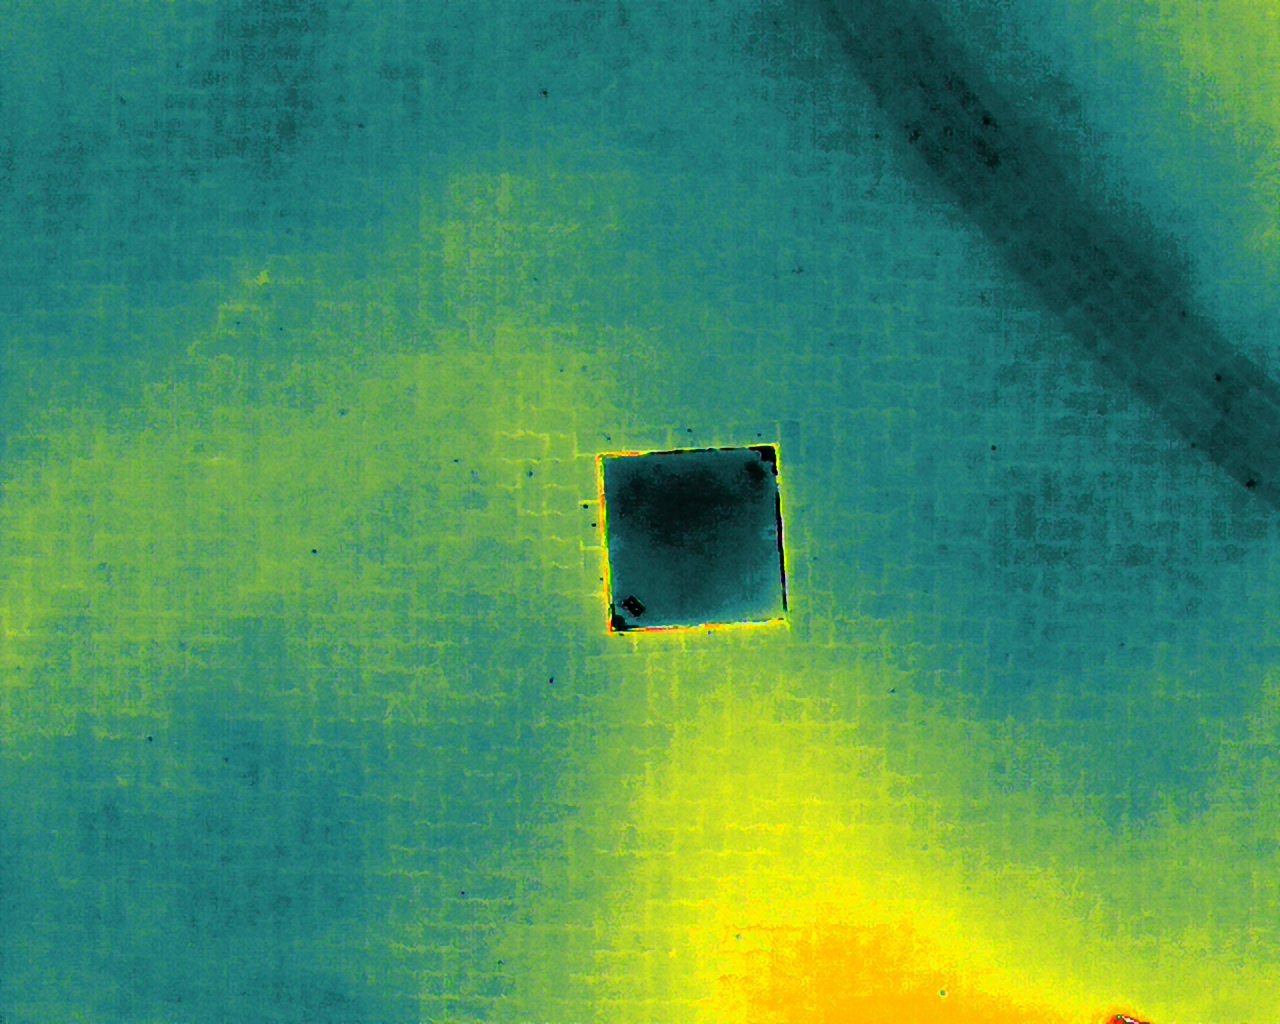

In [13]:
img.show()

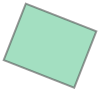

In [14]:
img.process()

In [17]:
img.to_shapefile()

In [16]:
img.image_cover.geom_type

'Polygon'

In [45]:
img.to_postgis()

In [46]:
#delete table content
with psycopg.connect(dbname="images",
                             user="luke",
                             password="lea",
                             host="postgis",
                             port="5432"
                            ) as conn:

            conn.execute(
                'DELETE FROM images.image_coverage;'
            )

In [47]:
# loop through folder and process all images
for image_name in image_names:
    image = M30TImage(image_directory + image_name)
    image.process()
    image.to_postgis()

Ich denke das was hier braucht ist für jedes image die db connection zu bauen also wohl besser umbauben
- entweder connection offen lassen
- oder erst in df speichern und dann gebündelt rüberschicken

In [ ]:
with psycopg.connect(dbname="images",
                             user="luke",
                             password="lea",
                             host="postgis",
                             port="5432"
                            ) as conn:
            info = psycopg.types.TypeInfo.fetch(conn, "geometry")
            psycopg.types.shapely.register_shapely(info, conn)
            cur = conn.execute(
                'SELECT * FROM images.image_coverage;'
            ).fetchall()
cur[:3]

In [ ]:
with psycopg.connect(dbname="images",
                     user="luke",
                     password="lea",
                     host="postgis",
                     port="5432"
                    ) as conn:
    conn.execute("""
        DROP TABLE IF EXISTS image_coverage;
        CREATE TABLE IF NOT EXISTS image_coverage (
            image TEXT PRIMARY KEY,
            coverage geometry
            )
        """)
    conn.execute(
        f"INSERT INTO image_coverage VALUES ('{ORG_FILE_PATH}', '{image_cover}')"
    )